## Quantum machine learning: Classification problem

Another example: for Divisive Clustering With Coresets, see this [tutorial](https://nvidia.github.io/cuda-quantum/latest/examples/python/tutorials/Divisive_clustering.html) in CUDA-Q doc page.

In [14]:
#pip install pandas
#pip install scikit-learn

import cudaq
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import scipy

In [15]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
data = mnist['data']
labels = np.array(mnist['target'], dtype=np.int8)
        
labels_zero = labels[labels==0] 
labels_one = labels[labels==1] 
binary_labels = np.hstack((labels_zero, labels_one))
digits_zero = data[labels==0]
digits_one = data[labels==1]
binary_digits = np.vstack((digits_zero, digits_one))

# Reduce the number of featues.     
pca = PCA(n_components=6)
sc = StandardScaler()
binary_digits = sc.fit_transform(binary_digits)
data = pca.fit_transform(binary_digits)

# Normalize data (Prepare data for angle encoding)
data = ((data-np.min(data))/(np.max(data)-np.min(data)))

x_train, x_test, y_train, y_test = train_test_split(data, binary_labels, test_size=0.2)

x_train=x_train[0:500]
x_test=x_test[0:200]
y_train=y_train[0:500]
y_test=y_test[0:200]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(y_train[0:10])

(500, 6) (200, 6) (500,) (200,)
[1 1 1 1 0 0 1 1 0 0]


In [16]:
#labels are -1 and 1

y_train=y_train*2-1
y_test=y_test*2-1

print(y_train[0:10])


[ 1  1  1  1 -1 -1  1  1 -1 -1]


## Quantum neural network


<div>
<img src="./QNN.png" width="500">
</div>


#### Angle encoding:

<div>
<img src="./encoding-angle.png" width="400">
</div>


#### Parameterized Quantum circuit:

Layers consisting of single qubit rotations and entanglers. To learn more, see this [paper](https://arxiv.org/pdf/1804.00633)


<div>
<img src="./entagle-layer.png" width="500">
</div>

In [17]:
cudaq.set_target("nvidia", option='mqpu')

@cudaq.kernel
def encoding(qubit:cudaq.qview, angles:list[float]):
    # Define gates and the qubits they act upon.

    qubit_num=qubit.size()
    for i in range(qubit_num):
        ry(angles[i], qubit[i])

@cudaq.kernel
def training_layer(qubit:cudaq.qview, alpha:list[float]):

    qubit_num=qubit.size()

    count=0
    for i in range(qubit_num):
        u3(alpha[count],alpha[count+1],alpha[count+2], qubit[i])
        count+=3
    
    for i in range(qubit_num-1):
        x.ctrl(qubit[i], qubit[i+1])
    
    x.ctrl(qubit[qubit_num-1], qubit[0])

    for i in range(qubit_num):
        u3(alpha[count],alpha[count+1],alpha[count+2], qubit[i])
        count+=3

    for i in range(qubit_num//2):
        x.ctrl(qubit[i], qubit[i+2])
    
    for i in range(qubit_num-1, qubit_num//2-1, -1):
        x.ctrl(qubit[i], qubit[i-2])
    
@cudaq.kernel
def qnn_kernel(qubit_count:int, data: list[float], alpha:list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qvector(qubit_count)

    # encoding data
    encoding(qubit,data)
    
    # training layer
    training_layer(qubit,alpha)

# Our hamiltonian will be the Z expectation value of our qubit.
ham = cudaq.spin.z(0)

In [18]:
qubit_count = x_train.shape[1]

np.random.seed(42)
alpha=np.random.normal(loc=0, scale=1, size=3*(qubit_count*2))
alpha=alpha.tolist()

bias=[0.0]
alpha=alpha+bias

print(alpha)
n=len(alpha)
print(alpha[n-1])

[0.4967141530112327, -0.13826430117118466, 0.6476885381006925, 1.5230298564080254, -0.23415337472333597, -0.23413695694918055, 1.5792128155073915, 0.7674347291529088, -0.4694743859349521, 0.5425600435859647, -0.46341769281246226, -0.46572975357025687, 0.24196227156603412, -1.913280244657798, -1.7249178325130328, -0.5622875292409727, -1.0128311203344238, 0.3142473325952739, -0.9080240755212109, -1.4123037013352915, 1.465648768921554, -0.22577630048653566, 0.06752820468792384, -1.4247481862134568, -0.5443827245251827, 0.11092258970986608, -1.1509935774223028, 0.37569801834567196, -0.600638689918805, -0.2916937497932768, -0.6017066122293969, 1.8522781845089378, -0.013497224737933921, -1.0577109289559004, 0.822544912103189, -1.2208436499710222, 0.0]
0.0


In [19]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def loss(alpha, main_kernel, ham, qubit_count, x_train, y_train):
    pred=[]

    param=alpha[0:n-2]
    async_observe=[]
    for image in range (len(x_train)):
    
        async_observe.append(cudaq.observe_async(main_kernel,ham, qubit_count,x_train[image],param,qpu_id=image%4))

    for result in async_observe:
        eig=result.get().expectation()
        pred.append(eig+alpha[n-1])

    return square_loss(y_train,pred)

def variational_classifier(alpha,main_kernel,ham,qubit_count,data_img):
    
    param=alpha[0:n-2]
    
    pred=[]
    async_result=[]
    for image in range(len(data_img)):
        async_result.append(cudaq.observe_async(main_kernel,ham, qubit_count,data_img[image],param,qpu_id=image%4))

    for result in async_result:
        eig=result.get().expectation()
        pred.append(np.sign(eig+alpha[n-1]))
    
    return pred

In [56]:

batch_size = 30
batch_index = np.random.randint(0, len(x_train), (batch_size,))
X_batch = x_train[batch_index]
Y_batch = y_train[batch_index]

loss_vals = []
acc_vals = []

def callback(xk):
        loss_vals.append(loss(xk, qnn_kernel, ham, qubit_count, X_batch, Y_batch))
        predictions=variational_classifier(xk,qnn_kernel,ham,qubit_count,x_train)
        acc_vals.append(accuracy(y_train, predictions))


result_opt=scipy.optimize.minimize(loss, alpha, method='COBYLA', args=(qnn_kernel, ham, qubit_count, X_batch, Y_batch), 
                                   callback=callback, tol=1e-8 )

alpha=result_opt.x

predictions=variational_classifier(alpha,qnn_kernel,ham,qubit_count,x_train)

acc_train = accuracy(y_train, predictions)

c_train=loss(alpha, qnn_kernel, ham, qubit_count, x_train, y_train)

print('Training data')
print(f'Cost: {c_train}, Accuracy: {np.round(acc_train, 2) * 100}%')

pred= variational_classifier(alpha,qnn_kernel,ham,qubit_count,x_test)
acc_test = accuracy(y_test, pred)

c_test=loss(alpha, qnn_kernel, ham, qubit_count, x_test, y_test)

print('Test data')
print(f'Cost: {c_test}, Accuracy: {np.round(acc_test, 2) * 100}%')


Training data
Cost: 0.7629360304346703, Accuracy: 99.0%
Test data
Cost: 0.7754650237474293, Accuracy: 98.0%


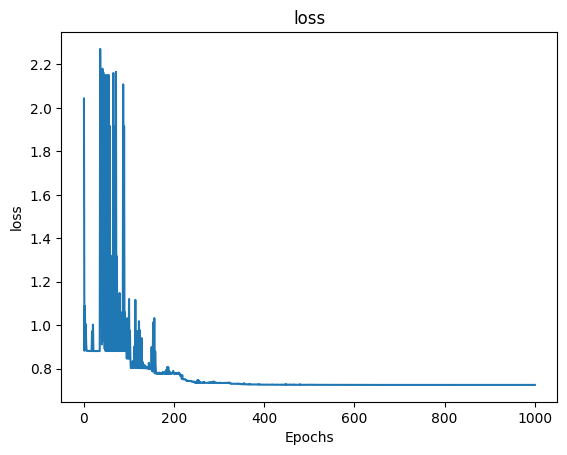

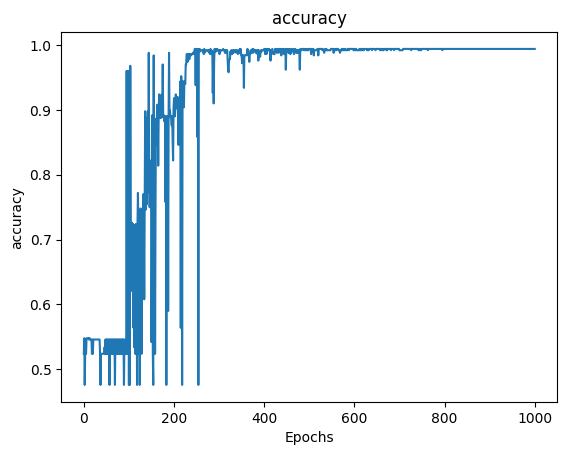

In [57]:
import matplotlib.pyplot as plt

plt.plot(loss_vals)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('loss')
plt.show()

plt.plot(acc_vals)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.show()

In [59]:
pd.DataFrame((pred, y_test), ('Predictions', 'Test')).T

,Predictions,Test
0,-1.0,-1.0
1,1.0,1.0
2,1.0,1.0
3,-1.0,-1.0
4,-1.0,-1.0
...,...,...
195,1.0,1.0
196,-1.0,1.0
197,1.0,1.0
198,-1.0,-1.0
